<a href="https://colab.research.google.com/github/tpglgk/CodingTest/blob/master/Tweetemotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re

import keras
from keras.layers import Embedding
import tensorflow as tf
from keras.preprocessing.text import text_to_word_sequence

# 0.필요한 데이터 다운

> **1) Transfer learning에 사용할 dataset**

트위터 감정분석


In [ ]:
!wget https://github.com/wldnjsdnjsdl/tweet_2/raw/main/tweet_training.csv

--2023-10-20 09:36:11--  https://github.com/wldnjsdnjsdl/tweet_2/raw/main/tweet_training.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wldnjsdnjsdl/tweet_2/main/tweet_training.csv [following]
--2023-10-20 09:36:12--  https://raw.githubusercontent.com/wldnjsdnjsdl/tweet_2/main/tweet_training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2479061 (2.4M) [text/plain]
Saving to: ‘tweet_training.csv’

tweet_training.csv  100%[===================>]   2.36M  --.-KB/s    in 0.08s   

2023-10-20 09:36:12 (31.1 MB/s) - ‘tweet_training.csv’ saved [2479061/2479061]



In [ ]:
data = pd.read_csv("/content/tweet_training.csv")

In [ ]:
data.head(5)

,emotion,text
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


Data 샘플 확인

In [ ]:
data['emotion'].value_counts() # 데이터 갯수 확인하기

worry         7433
neutral       6340
sadness       4828
happiness     2985
love          2068
surprise      1613
hate          1187
fun           1088
relief        1021
empty          659
enthusiasm     522
boredom        157
anger           98
Name: emotion, dtype: int64

> Data 전처리(label 만들어서 숫자 매기기)

In [ ]:
def label_race(row):
    if row == 'happiness':
        return 0
    elif row == 'sadness':
        return 1
    elif row == 'love':
        return 2
    elif row == 'surprise':
        return 3
    elif row == 'fun':
        return 4
    elif row == 'relief':
        return 5
    elif row == 'hate':
        return 6

In [ ]:
data['label'] = data['emotion'].apply(label_race)

> **2) Stanford GloVe embedding**

여러 임베딩 중 하나

* Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, *uncased*, 100d vectors)
* 60억개 토큰, 40만개 단어, 대소문자 구분x (다 소문자로만), feature dimension 100

Text파일로 구성되어있음

Reference

* https://nlp.stanford.edu/projects/glove/

* https://github.com/stanfordnlp/GloVe

In [ ]:
!wget https://github.com/Hwan-ho/class.NLP/raw/main/glove.6B.100d.zip
!wget https://github.com/Hwan-ho/class.NLP/raw/main/glove.6B.100d.z01

--2023-10-20 09:36:12--  https://github.com/Hwan-ho/class.NLP/raw/main/glove.6B.100d.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Hwan-ho/class.NLP/main/glove.6B.100d.zip [following]
--2023-10-20 09:36:12--  https://raw.githubusercontent.com/Hwan-ho/class.NLP/main/glove.6B.100d.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29583894 (28M) [application/zip]
Saving to: ‘glove.6B.100d.zip’

glove.6B.100d.zip   100%[===================>]  28.21M  --.-KB/s    in 0.1s    

2023-10-20 09:36:13 (192 MB/s) - ‘glove.6B.100d.zip’ saved [29583894/29583894]

--2023-10-20 09:36:13--  https://githu

In [ ]:
!zip -F /content/glove.6B.100d.zip --out /content/glove.zip
!unzip /content/glove.zip

Fix archive (-F) - assume mostly intact archive
 copying: glove.6B.100d.txt
Archive:  /content/glove.zip
  inflating: glove.6B.100d.txt       


In [ ]:
embedding_dict = dict() #단어와 인베딩의 쌍을 지어 저장(딕셔너리 형태로)

f = open('/content/glove.6B.100d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]

    # 100개의 값을 가지는 array로 변환
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close()

Embedding sample 확인


In [ ]:
embedding_dict.get("apple")

array([-0.5985   , -0.46321  ,  0.13001  , -0.019576 ,  0.4603   ,
       -0.3018   ,  0.8977   , -0.65634  ,  0.66858  , -0.49164  ,
        0.037557 , -0.050889 ,  0.6451   , -0.53882  , -0.3765   ,
       -0.04312  ,  0.51384  ,  0.17783  ,  0.28596  ,  0.92063  ,
       -0.49349  , -0.48583  ,  0.61321  ,  0.78211  ,  0.19254  ,
        0.91228  , -0.055596 , -0.12512  , -0.65688  ,  0.068557 ,
        0.55629  ,  1.611    , -0.0073642, -0.48879  ,  0.45493  ,
        0.96105  , -0.063369 ,  0.17432  ,  0.9814   , -1.3125   ,
       -0.15801  , -0.54301  , -0.13888  , -0.26146  , -0.3691   ,
        0.26844  , -0.24375  , -0.19484  ,  0.62583  , -0.7377   ,
        0.38351  , -0.75004  , -0.39053  ,  0.091498 , -0.36591  ,
       -1.4715   , -0.45228  ,  0.2256   ,  1.1412   , -0.38526  ,
       -0.06716  ,  0.57288  , -0.39191  ,  0.31302  , -0.29235  ,
       -0.96157  ,  0.15154  , -0.21659  ,  0.25103  ,  0.096967 ,
        0.2843   ,  1.4296   , -0.50565  , -0.51374  , -0.4721

*내가 사용할 preprocessing의 결과로 얻는 word들이 최대한 embedding vocabulary 안에 들어 있는 것이 좋음*

# 1. Preprocessing

> 데이터 범위 차이로 인해 1000부터 5000미만까지 데이터 프레임 만들어서 새로 구성하기

In [ ]:
data = data.dropna()
data = data.reset_index(drop=True) # 여기가 문제인듯

In [ ]:
data['emotion'].value_counts() # 데이터 다시 확인하기

sadness      4828
happiness    2985
love         2068
surprise     1613
hate         1187
fun          1088
relief       1021
Name: emotion, dtype: int64

In [ ]:
data

,emotion,text,label
0,sadness,Layin n bed with a headache ughhhh...waitin o...,1.0
1,sadness,Funeral ceremony...gloomy friday...,1.0
2,sadness,"I should be sleep, but im not! thinking about ...",1.0
3,sadness,@charviray Charlene my love. I miss you,1.0
4,sadness,@kelcouch I'm sorry at least it's Friday?,1.0
...,...,...,...
14785,fun,Hanging with my cousin Jimmy then hopefully ha...,4.0
14786,happiness,I had a great date last night...tried to find ...,0.0
14787,sadness,With alex,1.0
14788,happiness,@fureousangel that is comedy good luck my fri...,0.0


**Cleaning**

태그 ```<br />``` , 특수문자 \로 시작하는 단어 , 하이픈 (-) 을 공백으로 치환

[\b\@\w+\B]  : 언급 삭제 시 사용





In [ ]:
#세희가 준 코드(특정 문자만 삭제하는 코드)/|w*iï¿½w*|/bhttp\w+\B|-> 뒤에 숫자가 오는 경우도 있어서 이렇게 씀
#i = 0
#while i < len(data):
#  data["text"][i]= re.sub(r"<br />|\b\\\w+\B|-|´|\'|\b\@\w+\B |\b[a-zA-Z]+[0-9]+\B| |w*iï¿½w*|/bhttp\w+\B| ", " ", data["text"][i])
#  i += 1

In [ ]:
#환호 교수님 수정본(세희코드)/|w*iï¿½[0-9]*|/bhttp\w+\B|-> 뒤에 숫자가 올수도있고 안올 수도 있다.
#i = 0
#while i < len(data):
#  data["text"][i]= re.sub(r"<br />|\b\\\w+\B|-|´|\'|\b\@\w+\B |\b[a-zA-Z]+[0-9]+\B| |iï¿½[0-9]*|/bhttp\w+\B| ", " ", data["text"][i])
#  i += 1

In [ ]:
#환호 교수님의 코드(특수문자로만 이루어진 단어 삭제 코드)/|\b\W*\B|
#i = 0
#while i < len(data):
#  data["text"][i]= re.sub(r"<br />|\b\\\w+\B|-|´|\'|\b\@\w+\B |\b[a-zA-Z]+[0-9]+\B| |\b\W*\B|/bhttp\w+\B| ", " ", data["text"][i])
#  i += 1

In [ ]:
#시도 시ㄹ패
#i = 0
#while i < len(data):
#    data["text"][i] = re.sub(r"<br />|\b\\\w+\B|-|´|\'|\b\@\w+\B |\b[a-zA-Z]+[0-9]+\B| |/bhttp\w+\B| |:punct:|", " ", data["text"][i])
#    i += 1

In [ ]:
#0915교수님_(일단)최종본
#i = 0
#while i < len(data):
#  data["text"][i]= re.sub(r"<br />|\b\\\w+\B|-|´|\'|\b\@\w+\B |\b[a-zA-Z]+[0-9]+\B|\b\W*\B|/bhttp\w+\B|\b\w+(.)\1{2,}\w*", " ", data["text"][i])
#  i += 1

In [ ]:
i = 0
while i < len(data):
    data.loc[i, "text"] = re.sub(r"<br />|\b\\\w+\B|-|´|\'|\b\@\w+\B |\b[a-zA-Z]+[0-9]+\B|\b\W*\B|/bhttp\w+\B|\b\w+(.)\1{2,}\w*", " ", data.loc[i, "text"])
    i += 1

**Stemming** - 어간 추출 (혹은 suffix stripping, 어미 제거)

주의) 문장 끝에 마침표가 있을 때랑 없을 때 결과가 다름.

Porter stemmer: 규칙 기반 어간 추출

Ref: Porter, Martin F. "An algorithm for suffix stripping." Program 14.3 (1980): 130-137.

In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [ ]:
tokenLength = []
i = 0
while i < len(data):
    data.at[i, "text"] = stemmer.stem(data.at[i, "text"])
    tokenLength.append(len(data.at[i, "text"].split(' ')))
    i += 1

Padding을 쓸 때에는 평균 token 길이를 알고 있는 것이 좋음

10.90234375


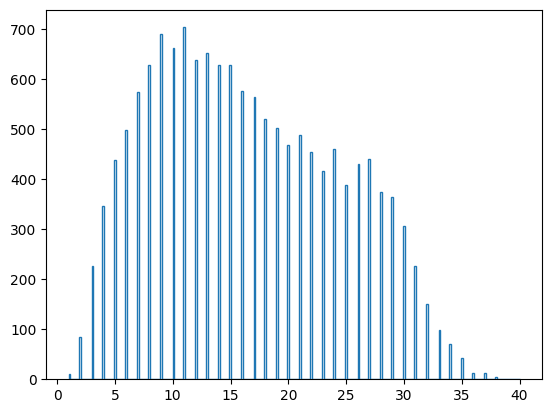

In [ ]:
import matplotlib.pyplot as plt
counts, bins = np.histogram(tokenLength, bins=256)
plt.stairs(counts, bins)
print(bins[np.argmax(counts)])
#plt.hist(tokenLength, bins=256)

**Tokenization - Keras TextVectorization 활용**

Ref: https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

* TextVectorization 함수

1. Standardize each example (usually lowercasing + punctuation stripping)
2. Split each example into substrings (usually words)
3. Recombine substrings into tokens (usually ngrams)
4. Index tokens (associate a unique int value with each token)
5. Transform each example using this index, either into a vector of ints or a dense float vector.

(아직 keras에서 Lemmatization은 지원 X)

```
tf.keras.layers.TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8',
    **kwargs
)
```

In [ ]:
from keras.layers import TextVectorization

In [ ]:
VOCAB_SIZE = 10000 #len(embedding_dict)
encoder = TextVectorization(max_tokens=VOCAB_SIZE, ragged=True) # ragged array: 열의 갯수가 행마다 다른 행렬, tensorflow는 감사하게도 ragged tensor를 지원함
encoder.adapt(data["text"])

In [ ]:
voc = encoder.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
print(len(voc))
voc[:20]

10000


['',
 '[UNK]',
 'i',
 'to',
 'the',
 'a',
 'my',
 'it',
 'and',
 'you',
 'is',
 'in',
 'for',
 't',
 'of',
 's',
 'that',
 'so',
 'on',
 'm']

Normalization sample 확인

In [ ]:
print(data["text"][0])
print(" ".join(np.array(voc)[encoder(data["text"][0])]))

layin n bed with a headache    on your  
[UNK] n bed with a headache on your


**Encoding 결과 샘플**



In [ ]:
encoder(data["text"][:2])

<tf.RaggedTensor [[1, 289, 207, 26, 5, 570, 18, 48], [2161]]>

**Encoding matrix 구하기**

* Missing word가 적을수록 전처리가 잘 된 것

* Missing word가 너무 많으면 모델 성능에 영향이 클 수 있음

* Tip: 사용하는 vocabulary 갯수를 한정시켜 놓으면 자주 나온 단어 위주로 판단함

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0
missedList = []

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        missedList.append(word)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 7473 words (2527 misses)


In [ ]:
missedList

['',
 '[UNK]',
 'lt3',
 'hahaha',
 'tinyurlcom',
 'tommcfly',
 'lmao',
 'plurkcomp',
 'mitchelmusso',
 'blipfm',
 'mileycyrus',
 'bday',
 'jonasbrothers',
 'idk',
 'sorri',
 'ddlovato',
 'bitly',
 'alreadi',
 'anymor',
 'twitt',
 'davidarchie',
 'hahah',
 'followfriday',
 'dougiemcfly',
 'headach',
 'quoti',
 'iï¿½m',
 'awesom',
 'weath',
 'hahahaha',
 'funni',
 'thanx',
 'retrorewind',
 'peopl',
 'twpp',
 'robluketic',
 'everyon',
 'dannywood',
 'jonathanrknight',
 'itï¿½s',
 'wwwyoutubecomchineselearn',
 'sux',
 'summ',
 'starwarsday',
 'quotthe',
 'movi',
 'earli',
 'dhughesy',
 '2moro',
 'tumblrcom',
 'leav',
 'heyy',
 'excit',
 'eith',
 'amaz',
 'wossy',
 'togeth',
 'selenagomez',
 'rofl',
 'nkotb',
 'nickcarter',
 'lt33',
 'littlefletcher',
 'iamdiddy',
 'hungri',
 'donniewahlberg',
 '2morrow',
 'ï¿½',
 'outsid',
 'offic',
 'hahahahaha',
 'hadn',
 'gunna',
 'bumm',
 'amberbenson',
 'ahaha',
 'youquot',
 'yeahh',
 'yayy',
 'urgh',
 'ughh',
 'tmrw',
 'theellenshow',
 'quotwhat',
 '

**Embedding layer로 만들어놓기**

In [ ]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

# 2. Network architecture


keras.layers.SimpeRNN

* inputs = [batch, timesteps, feature]

In [ ]:
from tensorflow.keras.layers import LSTM, Dropout

In [ ]:

# 입력 레이어 정의
inputText = keras.Input(shape=(1), dtype=tf.string)

# 텍스트를 임베딩하는 층
encodedText = encoder(inputText)
embeddedText = embedding_layer(encodedText)

# SimpleRNN 층 추가
x = keras.layers.SimpleRNN(128, return_sequences=True, activation='relu')(embeddedText)

# LSTM 층 추가
x = LSTM(64, return_sequences=False)(x)

# Dropout 층 추가
x = Dropout(0.2)(x)  # 20%의 뉴런을 비활성화하여 과적합 방지

# 출력 레이어 추가
output = keras.layers.Dense(7, activation='softmax')(x)  # 13개의 클래스를 분류하기 위한 출력 레이어

# 모델 정의
myMdl = keras.Model(inputText, output, name="myMdl")

# 각 층의 정보를 확인하고 싶을 때 사용할 수 있는 모델 정의 (word embedding 결과 확인용)
myMdl_wordEmbedding = keras.Model(inputText, embeddedText, name="wordEmbedding")

In [ ]:
myMdl.summary()

Model: "myMdl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 100)         1000200   
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 128)         29312     
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                             

**샘플 출력 확인하기**

In [ ]:
np.array(data["text"][:2]).reshape(-1,1)

array([['layin n bed with a headache    on your  '],
       ['funeral    ']], dtype=object)

In [ ]:
myMdl_wordEmbedding.predict(np.array(data["text"][:2]).reshape(-1,1))

1/1 [==============================] - 0s 107ms/step


<tf.RaggedTensor [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
   0.0, 0.0],
  [-1.0889, 0.15505, 0.31952, 0.28231, -0.26882, 0.14778, 0.35143, 0.3691,
   -0.14636, 0.46264, 0.72031, -0.93214, -0.25624, 0.59452, 0.36191,
   -0.17785, -0.38944, 0.46279, 0.02542, 0.049203, 1.0677, -0.00014154,
   0.20156, -0.41351, -0.05016, 0.51361, 1.1236, 0.31335, 0.62001,
   -0.31925, 0.85093, 0.75885, -0.24657, 0.18882, 0.51676, 0.22059, 1.0004,
   -0.074258, 0.59846, -0.25869, 0.2831, -0.91471, -0.33909, -0.6421,
   -0.19543, 0.063651, -0.858

In [ ]:
myMdl.predict(np.array(data["text"][:2]).reshape(-1,1))

1/1 [==============================] - 5s 5s/step


array([[0.15377866, 0.09591627, 0.12084666, 0.12122529, 0.13917308,
        0.1851974 , 0.1838626 ],
       [0.12804078, 0.14398073, 0.1408087 , 0.14669287, 0.13465327,
        0.1501377 , 0.15568595]], dtype=float32)

In [ ]:
myMdl_wordEmbedding.predict(np.array(data["text"][:2]).reshape(-1,1)).shape

1/1 [==============================] - 0s 20ms/step


TensorShape([2, None, 100])

# 3. Training 및 결과확인

In [ ]:
myMdl.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3),loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = myMdl.fit(x=np.array(data["text"]), y=np.array(data["label"]), batch_size=2048, epochs=300, validation_split=0.1)

Epoch 1/300
7/7 [==============================] - 7s 209ms/step - loss: 1.8315 - accuracy: 0.3084 - val_loss: 2.1064 - val_accuracy: 0.0683
Epoch 2/300
7/7 [==============================] - 1s 82ms/step - loss: 1.7682 - accuracy: 0.3538 - val_loss: 1.9100 - val_accuracy: 0.0987
Epoch 3/300
7/7 [==============================] - 1s 74ms/step - loss: 1.7511 - accuracy: 0.3525 - val_loss: 2.1397 - val_accuracy: 0.0683
Epoch 4/300
7/7 [==============================] - 1s 81ms/step - loss: 1.7361 - accuracy: 0.3616 - val_loss: 1.9352 - val_accuracy: 0.1102
Epoch 5/300
7/7 [==============================] - 1s 78ms/step - loss: 1.7390 - accuracy: 0.3508 - val_loss: 1.9394 - val_accuracy: 0.0926
Epoch 6/300
7/7 [==============================] - 1s 79ms/step - loss: 1.7031 - accuracy: 0.3750 - val_loss: 1.7733 - val_accuracy: 0.3036
Epoch 7/300
7/7 [==============================] - 0s 70ms/step - loss: 1.7047 - accuracy: 0.3754 - val_loss: 2.0825 - val_accuracy: 0.0825
Epoch 8/300
7/7 [==

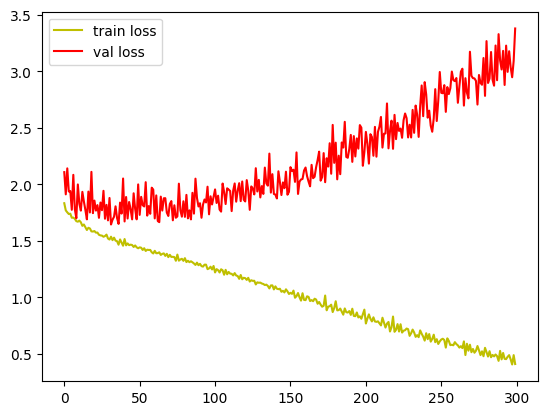

In [ ]:
plt.figure()
plt.plot(history.history['loss'], 'y', label='train loss')
plt.plot(history.history['val_loss'], 'r', label='val loss')
plt.legend()

In [ ]:
test_text = "You are so boring. I really hate you. I would rather just sleep at home than hang out with you."
print(f'원본: {test_text}')

test_text = stemmer.stem(test_text)
print(f'전처리 후:{" ".join(np.array(voc)[encoder(test_text)])}')

prediction = myMdl.predict(np.array(test_text).reshape(-1,1))
print(f'예측 점수: {prediction}')

if np.any(prediction > 0.5):
    print("예측 결과: 긍정")
else:
    print("예측 결과: 부정")

원본: You are so boring. I really hate you. I would rather just sleep at home than hang out with you.
전처리 후:you are so boring i really hate you i would rather just sleep at home than hang out with you
1/1 [==============================] - 1s 545ms/step
예측 점수: [[3.16267833e-03 6.78170502e-01 5.99038415e-03 5.19496971e-04
  1.05596424e-04 2.60350753e-05 3.12025219e-01]]
예측 결과: 긍정


In [ ]:
test_text = "You made it today too. You did a great job. I am proud of you."
print(f'원본: {test_text}')

test_text = stemmer.stem(test_text)
print(f'전처리 후:{" ".join(np.array(voc)[encoder(test_text)])}')

prediction = myMdl.predict(np.array(test_text).reshape(-1,1))
print(f'예측 점수: {prediction}')


if np.any(prediction > 0.5):
    print("예측 결과: 긍정")
else:
    print("예측 결과: 부정")

원본: You made it today too. You did a great job. I am proud of you.
전처리 후:you made it today too you did a great job i am proud of you
1/1 [==============================] - 0s 27ms/step
예측 점수: [[3.5599968e-03 1.2911086e-04 2.0902272e-02 1.6284481e-04 2.8963790e-03
  9.7229719e-01 5.2152718e-05]]
예측 결과: 긍정


test

In [ ]:
!wget https://github.com/wldnjsdnjsdl/tweet_2/raw/main/tweet_test.csv

--2023-10-20 09:40:27--  https://github.com/wldnjsdnjsdl/tweet_2/raw/main/tweet_test.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wldnjsdnjsdl/tweet_2/main/tweet_test.csv [following]
--2023-10-20 09:40:27--  https://raw.githubusercontent.com/wldnjsdnjsdl/tweet_2/main/tweet_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 809126 (790K) [text/plain]
Saving to: ‘tweet_test.csv’

tweet_test.csv      100%[===================>] 790.16K  --.-KB/s    in 0.06s   

2023-10-20 09:40:28 (13.5 MB/s) - ‘tweet_test.csv’ saved [809126/809126]



In [ ]:
test = pd.read_csv("/content/tweet_test.csv")

In [ ]:
test.head(5)

,emotion,text
0,happiness,@jesfive SWEEEEET - San Fran is awesome!!!! L...
1,neutral,is hangin with the love of my life. Tessa McCr...
2,worry,I've Got An Urge To Make Music Like Massively....
3,neutral,@lacrossehawty rofl uh huh
4,worry,"@fankri haha! thanks, Tiff it went well, but..."


In [ ]:
test.shape

(10000, 2)

In [ ]:
test['emotion'].value_counts() # 데이터 갯수 확인하기

neutral       2297
happiness     2224
love          1774
worry         1026
fun            688
surprise       574
relief         505
sadness        337
enthusiasm     237
empty          168
hate           136
boredom         22
anger           12
Name: emotion, dtype: int64

In [ ]:
def label_race(row):
    if row == 'happiness':
        return 0
    elif row == 'sadness':
        return 1
    elif row == 'love':
        return 2
    elif row == 'surprise':
        return 3
    elif row == 'fun':
        return 4
    elif row == 'relief':
        return 5
    elif row == 'hate':
        return 6

In [ ]:
test['label'] = test['emotion'].apply(label_race)

In [ ]:
test = test.dropna()
test = test.reset_index(drop=True) # 여기가 문제인듯

In [ ]:
test['emotion'].value_counts() # 데이터 다시 확인하기

happiness    2224
love         1774
fun           688
surprise      574
relief        505
sadness       337
hate          136
Name: emotion, dtype: int64

In [ ]:
test

,emotion,text,label
0,happiness,@jesfive SWEEEEET - San Fran is awesome!!!! L...,0.0
1,love,@alyssaisntcool hahah i loveeee him though.,2.0
2,happiness,@bunnydrumming Hi bunny! I recently have subcr...,0.0
3,love,@CChiron Dude you rock,2.0
4,love,@cassfern yes. and it was REALLY good. even th...,2.0
...,...,...,...
6233,happiness,Succesfully following Tayla!!,0.0
6234,love,Happy Mothers Day All my love,2.0
6235,love,Happy Mother's Day to all the mommies out ther...,2.0
6236,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,0.0


In [ ]:
i = 0
while i < len(test):
    test.loc[i, "text"] = re.sub(r"<br />|\b\\\w+\B|-|´|\'|\b\@\w+\B |\b[a-zA-Z]+[0-9]+\B|\b\W*\B|/bhttp\w+\B|\b\w+(.)\1{2,}\w*", " ", test.loc[i, "text"])
    i += 1

In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [ ]:
tokenLength = []
i = 0
while i < len(test):
    test.at[i, "text"] = stemmer.stem(test.at[i, "text"])
    tokenLength.append(len(test.at[i, "text"].split(' ')))
    i += 1

9.90625


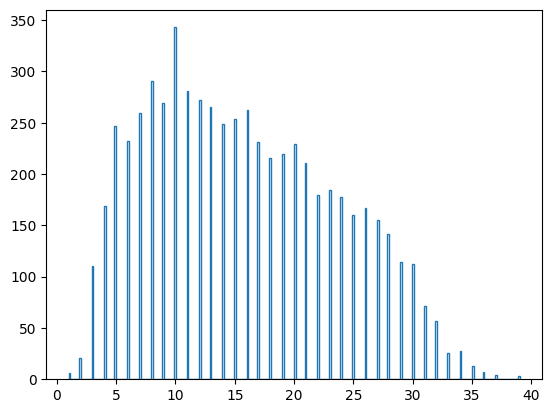

In [ ]:
import matplotlib.pyplot as plt
counts, bins = np.histogram(tokenLength, bins=256)
plt.stairs(counts, bins)
print(bins[np.argmax(counts)])
#plt.hist(tokenLength, bins=256)

In [ ]:
from keras.layers import TextVectorization

In [ ]:
VOCAB_SIZE = 10000 #len(embedding_dict)
encoder = TextVectorization(max_tokens=VOCAB_SIZE, ragged=True) # ragged array: 열의 갯수가 행마다 다른 행렬, tensorflow는 감사하게도 ragged tensor를 지원함
encoder.adapt(test["text"])

In [ ]:
voc = encoder.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
print(len(voc))
voc[:20]

10000


['',
 '[UNK]',
 'i',
 'the',
 'to',
 'a',
 'you',
 'and',
 's',
 'day',
 'my',
 'it',
 'for',
 'is',
 'happy',
 'in',
 'of',
 'that',
 'on',
 'love']

In [ ]:
print(test["text"][0])
print(" ".join(np.array(voc)[encoder(test["text"][0])]))

@jesfive    san fran is    love it ther
jesfive san fran is love it ther


In [ ]:
encoder(test["text"][:2])

<tf.RaggedTensor [[8478, 1294, 3348, 13, 19, 11, 315], [1, 602, 2, 150, 153]]>

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0
missedList = []

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        missedList.append(word)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 6496 words (3504 misses)


In [ ]:
missedList

['',
 '[UNK]',
 'lt3',
 'hahaha',
 'blipfm',
 'lmao',
 'awesom',
 'bday',
 'jonathanrknight',
 'tinyurlcom',
 'mommi',
 'jtimberlake',
 'hahah',
 'bitly',
 'trimkwk9',
 'quoti',
 'amaz',
 'twitt',
 'plurkcomp',
 'retrorewind',
 'mrskutcher',
 'funni',
 'everyon',
 'ddlovato',
 'thanx',
 'mommys',
 'mariahcarey',
 'hahahaha',
 'famili',
 'bradiewebbstack',
 'snipurlcom',
 'officialtila',
 'movi',
 'iphon',
 'tweeps',
 'tinyurlcomfreeringring',
 'quotthe',
 'lt33',
 'followfriday',
 'excit',
 'solangeknowles',
 'sanctuarysunday',
 'peopl',
 'mothersday',
 'mileycyrus',
 'jasonbradbury',
 'debbiefletcher',
 'dawnrichard',
 'davidhenrie',
 'andyclemmensen',
 'yeahh',
 'tomorow',
 'startrek',
 'perezhilton',
 'nkotb',
 'jordanknight',
 'johncmayer',
 'jimmyfallon',
 'idk',
 'devyra',
 'davidarchie',
 'chocol',
 'ztnewetnorb',
 'yayy',
 'ustream2uhs',
 'unfollow',
 'twitterverse',
 'twitterland',
 'tumblrcom',
 'tommcfly',
 'tomfelton',
 'thanku',
 'souljaboytellem',
 'sambennington',
 'rofl

In [ ]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
myMdl.evaluate(x=np.array(test["text"]),y=np.array(test["label"]== 0))

195/195 [==============================] - 3s 11ms/step - loss: 3.2176 - accuracy: 0.2905


[3.2176353931427, 0.2904777228832245]

In [ ]:
prediction

array([[3.5599968e-03, 1.2911086e-04, 2.0902272e-02, 1.6284481e-04,
        2.8963790e-03, 9.7229719e-01, 5.2152718e-05]], dtype=float32)

In [ ]:
test_text = "I am happy"
print(f'원본: {test_text}')

test_text = stemmer.stem(test_text)
print(f'전처리 후:{" ".join(np.array(voc)[encoder(test_text)])}')

prediction = myMdl.predict(np.array(test_text).reshape(-1,1))
print(f'예측 점수: {prediction}')

if np.any((0 <= prediction) & (prediction < 1)):
    print("예측 결과: happiness")
elif np.any((1 <= prediction) & (prediction < 2)):
    print("예측 결과: love")
elif np.any((2 <= prediction) & (prediction < 3)):
    print("예측 결과: fun")
elif np.any((3 <= prediction) & (prediction < 4)):
    print("예측 결과: surprise")
elif np.any((4 <= prediction) & (prediction < 5)):
    print("예측 결과: relief")
elif np.any((5 <= prediction) & (prediction < 6)):
    print("예측 결과: sadness")
else:
    print("예측결과: hate")

원본: I am happy
전처리 후:i am happi
1/1 [==============================] - 0s 32ms/step
예측 점수: [[0.11397451 0.80441046 0.0307972  0.01514811 0.01251103 0.0183004
  0.00485821]]
예측 결과: happiness


In [ ]:
test_text = "I love you"
print(f'원본: {test_text}')

test_text = stemmer.stem(test_text)
print(f'전처리 후:{" ".join(np.array(voc)[encoder(test_text)])}')

prediction = myMdl.predict(np.array(test_text).reshape(-1,1))
print(f'예측 점수: {prediction}')


원본: I love you
전처리 후:i love y
1/1 [==============================] - 0s 31ms/step
예측 점수: [[8.2143797e-03 1.2319559e-02 9.7894853e-01 1.1918784e-04 3.8464786e-05
  3.1835362e-04 4.1560292e-05]]


In [ ]:
prediction

array([[8.2143797e-03, 1.2319559e-02, 9.7894853e-01, 1.1918784e-04,
        3.8464786e-05, 3.1835362e-04, 4.1560292e-05]], dtype=float32)

In [ ]:
test_text = "i had the best day ever! i missed him. more tomorrow too"
print(f'원본: {test_text}')

test_text = stemmer.stem(test_text)
print(f'전처리 후:{" ".join(np.array(voc)[encoder(test_text)])}')

prediction = myMdl.predict(np.array(test_text).reshape(-1,1))
print(f'예측 점수: {prediction}')

if np.any((0 <= prediction) & (prediction < 1)):
    print("예측 결과: happiness")
elif np.any((1 <= prediction) & (prediction < 2)):
    print("예측 결과: love")
elif np.any((2 <= prediction) & (prediction < 3)):
    print("예측 결과: fun")
elif np.any((3 <= prediction) & (prediction < 4)):
    print("예측 결과: surprise")
elif np.any((4 <= prediction) & (prediction < 5)):
    print("예측 결과: relief")
elif np.any((5 <= prediction) & (prediction < 6)):
    print("예측 결과: sadness")
else:
    print("예측 결과: hate")

원본: i had the best day ever! i missed him. more tomorrow too
전처리 후:i had the best day ever i missed him more tomorrow too
1/1 [==============================] - 0s 35ms/step
예측 점수: [[6.3328617e-03 9.9346739e-01 1.7584447e-04 9.8414339e-06 5.2812834e-07
  1.1530386e-05 1.9911408e-06]]
예측 결과: happiness


In [ ]:
#Preprocess text
X_train = np.array(data['text'])
y_train = np.array(data['emotion'])

X_test = np.array(test['text'])
y_test = np.array(test['emotion'].apply(label_race))

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


# 테스트 데이터에 대한 예측 수행
y_pred = myMdl.predict(X_test.reshape(-1,1))
y_pred= np.argmax(y_pred,axis=1)

# Confusion matrix 생성
confusion = confusion_matrix(y_test, y_pred)

# Confusion matrix 출력
print("Confusion Matrix:")
print(confusion)

# 분류 보고서 출력 (옵션)
#classification_rep = classification_report(y_test, y_pred, target_names=["클래스 0", "클래스 1"])
#print("Classification Report:")
#print(classification_rep)


195/195 [==============================] - 2s 11ms/step
Confusion Matrix:
[[1018  375  185  180  170  260   36]
 [  85  141   17   33   20   25   16]
 [ 704  270  430  107   90  157   16]
 [ 190  138   45   92   32   66   11]
 [ 254  151   49   78   64   75   17]
 [ 183  127   35   37   23   91    9]
 [  21   54    6   18    6   13   18]]


In [ ]:
from sklearn.metrics import roc_curve

Confusion Matrix : 
 [[1018  375  185  180  170  260   36]
 [  85  141   17   33   20   25   16]
 [ 704  270  430  107   90  157   16]
 [ 190  138   45   92   32   66   11]
 [ 254  151   49   78   64   75   17]
 [ 183  127   35   37   23   91    9]
 [  21   54    6   18    6   13   18]]


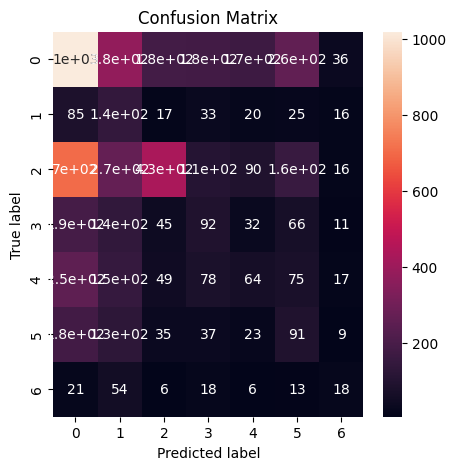

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix : \n {}'.format(cm))

# 혼동 행렬을 출력합니다
import seaborn as sns
fig = plt.figure(figsize=(5,5))
ax = sns.heatmap(cm, annot=True)
ax.set(title='Confusion Matrix',
            ylabel='True label',
            xlabel='Predicted label')
fig.savefig("decistion_tree.png")

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred,
                 labels=[0, 1])

array([[1018,  375],
       [  85,  141]])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

## performance metrics
accuracy = accuracy_score(y_test, y_pred)

precision, recall, fscore, support = \
    precision_recall_fscore_support(y_test, y_pred)

print('Accuracy   : %.3f' %accuracy) # (102+164)/(102+16+3+164)
print('Precision  : %.3f' %precision[0]) # 102/(102+3)
print('Recall     : %.3f' %recall[0]) # 102/(102+16)
print('Specificyty: %.3f' %recall[1]) # 164/(3+164)
print('F1-Score   : %.3f' %fscore[0])

Accuracy   : 0.297
Precision  : 0.415
Recall     : 0.458
Specificyty: 0.418
F1-Score   : 0.435


In [ ]:
from sklearn.metrics import classification_report

target_names = ['happiness', 'sadness', 'love', 'suprise', 'fun', 'relief', 'hate']
print(classification_report(y_test, y_pred,
                            target_names=target_names))

              precision    recall  f1-score   support

   happiness       0.41      0.46      0.44      2224
     sadness       0.11      0.42      0.18       337
        love       0.56      0.24      0.34      1774
     suprise       0.17      0.16      0.16       574
         fun       0.16      0.09      0.12       688
      relief       0.13      0.18      0.15       505
        hate       0.15      0.13      0.14       136

    accuracy                           0.30      6238
   macro avg       0.24      0.24      0.22      6238
weighted avg       0.36      0.30      0.30      6238

